In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

import torch 
import torch.nn as nn
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import glymur

In [2]:
class_min_dict = {"amphibole":(52,82,52),
              "apophyllite":(0,255,0),
              "aspectral":(209,209,209),
              "biotite":(128,0,0),
              "carbonate":(0,255,255),
              "carbonate-actinolite":(44,109,0),
              "chlorite":(0,192,0),
              "clinochlore":(45,95,45),
              "dickite":(148,138,84),
              "epidote":(188,255,55),
              "iron carbonate":(185,255,255),
              "iron oxide":(255,154,0),
              "gypsum":(213,87,171),
              "kaolinite":(191,183,143),
              "montmorillonite":(175,175,255),
                "NA":(0,0,0),
              "nontronite":(105,105,255),
              "phlogopite":(88, 0, 0),
              "prehnite":(70, 70, 220),
              "sericite":(58,102,156),
              "silica":(166,166,166),
              "tourmaline":(255,0,0),
                "UNK1":(83, 141, 213),
                "UNK2":(155, 187, 89),
                "UNK3":(0, 108, 105),
              "vermiculite":(95, 100, 200)
             }

class_RGB_dict = {v: k for k, v in class_min_dict.items()}

In [3]:
path = '../img-rgb-50u'
label_path = '../img-clm-phy'
alt_label_path = '../img-sm-chl'
img_list = [i for i in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, i))]
# print(img_list)

## Check for missing RGB values

In [7]:
# s = set()
# for i in range(img.shape[0]):
#     for j in range(img.shape[1]):
#         s.add(tuple(img[i,j]))
        
# for i in s:
#     if i not in class_RGB_dict.keys():
#         print("{} Not found".format(i))

% of known image contents:  0.99995
% of known image contents:  0.99999375
% of known image contents:  0.99996875
% of known image contents:  1.0
% of known image contents:  1.0
% of known image contents:  0.9999125
% of known image contents:  0.99999375
% of known image contents:  1.0
% of known image contents:  1.0
% of known image contents:  1.0
% of known image contents:  1.0
% of known image contents:  0.99860625
% of known image contents:  1.0
% of known image contents:  1.0
% of known image contents:  0.99810625
% of known image contents:  1.0
% of known image contents:  0.99991875
% of known image contents:  1.0
% of known image contents:  0.9999875
% of known image contents:  1.0
% of known image contents:  1.0
% of known image contents:  1.0
% of known image contents:  0.99996875
% of known image contents:  0.99998125
% of known image contents:  0.99996875
% of known image contents:  0.99998125
% of known image contents:  0.9997375
% of known image contents:  1.0
% of known i

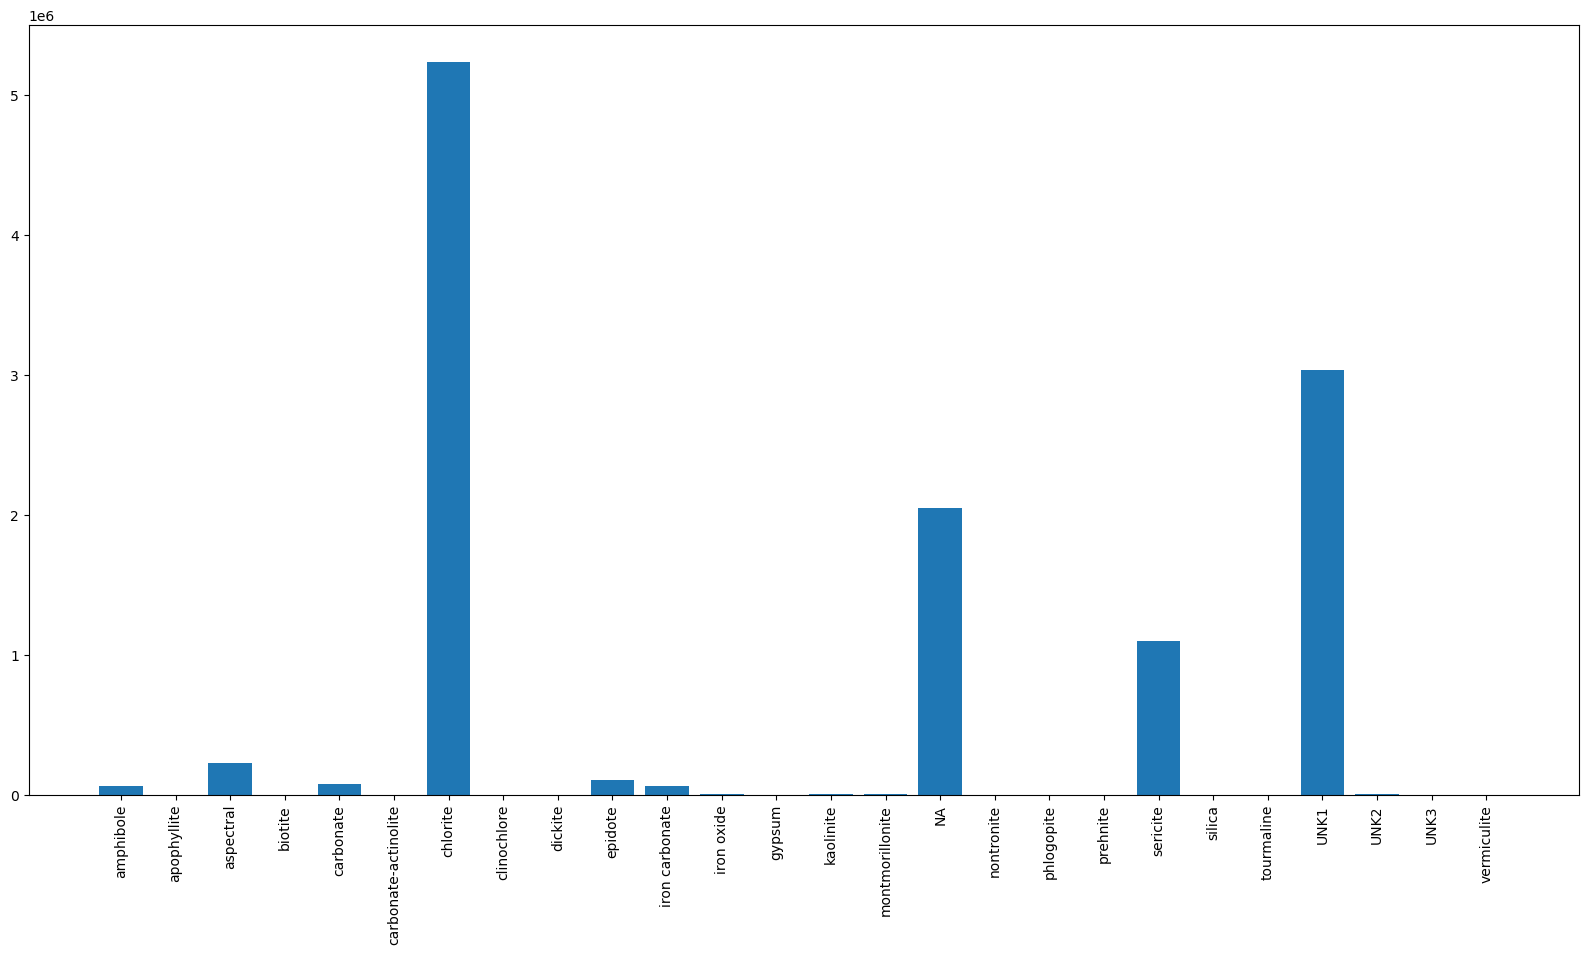

In [4]:
class_hist_dict = {}
for i in list(class_min_dict.keys()):
    class_hist_dict[i] = 0

for p in img_list:
    img = cv2.imread(os.path.join(label_path,p))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    total = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if tuple(img[i,j]) in class_RGB_dict:
                total +=1
                class_hist_dict[class_RGB_dict[tuple(img[i,j])]] =  class_hist_dict[class_RGB_dict[tuple(img[i,j])]] + 1
    print('% of known image contents: ', total/np.prod(img.shape[:2]))

plt.figure(figsize=(20,10));
plt.bar(list(class_hist_dict.keys()),list(class_hist_dict.values()));
plt.xticks(rotation='vertical');

## Create masking function

In [68]:
def create_mask(img,mineral,class_dict):
    #Input images should be channels x height x width
    mask = np.zeros(img.shape[1:])

    for i in range(img.shape[1]):
        for j in range(img.shape[2]):
            if tuple(img[:,i,j]) == class_dict[mineral]:
                mask[i,j] = 1
    return mask

def mask_RGB(RGB,img,class_dict):
    #Input images should be channels x height x width
    #Set all NA pixels in the class map to 0 in the RGB

    for i in range(img.shape[1]):
        for j in range(img.shape[2]):
            if tuple(img[:,i,j]) == class_dict["NA"]:
                RGB[:,i,j] = 0
    return RGB

## Define U-NET architecture

In [69]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

In [70]:
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

In [71]:
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

In [72]:
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        #""" Encoder """
        self.e1 = encoder_block(3, 128) #3,64 original size
        self.e2 = encoder_block(128, 256) #64, 128
        self.e3 = encoder_block(256, 512) #128, 256
        self.e4 = encoder_block(512, 1024) #256, 512
        #""" Bottleneck """
        self.b = conv_block(1024, 2048) #512, 1024
        #""" Decoder """
        self.d1 = decoder_block(2048, 1024) #1024, 512
        self.d2 = decoder_block(1024, 512) #512, 256
        self.d3 = decoder_block(512, 256) #256, 128
        self.d4 = decoder_block(256, 128) #128, 64
        #""" Classifier """
        self.outputs = nn.Conv2d(128, 1, kernel_size=1, padding=0) #64,1
    def forward(self, inputs):
        #""" Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        #""" Bottleneck """
        b = self.b(p4)
        #""" Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        #""" Classifier """
        outputs = self.outputs(d4)
        outputs = torch.sigmoid(outputs)
        return outputs

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_unet()
model = model.to(device)
# model(torch.Tensor(np.transpose(np.expand_dims(img[:64,:64,:],axis=0),[0,3,1,2])))

## Create dataloader

In [77]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, label_dir, mineral_type, class_dict, thresh, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_list = sorted([f for f in os.listdir(self.img_dir) if os.path.isfile(os.path.join(img_dir,f))])
        self.label_list = sorted([f for f in os.listdir(self.label_dir) if os.path.isfile(os.path.join(label_dir,f))])
        self.transform = transform
        self.target_transform = target_transform
        self.mineral_type = mineral_type
        self.class_dict = class_dict
        self.thresh = thresh
        
        #class map
        self.cm_dir = '../img-clm-phy'
        self.cm_list = sorted([f for f in os.listdir(self.cm_dir) if os.path.isfile(os.path.join(self.cm_dir,f))])


    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_list[idx])
        label_path = os.path.join(self.label_dir, self.label_list[idx])
        cm_path = os.path.join(self.cm_dir, self.cm_list[idx])
            
        #Get header info
        j2k = glymur.Jp2k(img_path)
        j2k2 = glymur.Jp2k(label_path)
        
        rgb_tiepoint = j2k.box[3].data['ModelTiePoint'][3:6]
        cm_tiepoint = j2k2.box[3].data['ModelTiePoint'][3:6]
        rgb_res = j2k.box[3].data['ModelPixelScale'][0]
        cm_res = rgb_res*10
        
        #Read images
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        
        label = cv2.imread(label_path)
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
        
        cm = cv2.imread(cm_path)
        cm = cv2.cvtColor(cm, cv2.COLOR_BGR2RGB)
        
        #Resize and transpose
        rgb_box = (rgb_tiepoint,rgb_tiepoint+[img.shape[1]*rgb_res,-img.shape[0]*rgb_res,0])
        cm_box = (cm_tiepoint,cm_tiepoint+[label.shape[1]*cm_res,-label.shape[0]*cm_res,0])
        
        img = cv2.copyMakeBorder(img, -min(int((rgb_box[0][1]-cm_box[0][1])/cm_res),0),
                          max(int((rgb_box[1][1]-cm_box[1][1])/cm_res),0),
                          max(int((rgb_box[0][0]-cm_box[0][0])/cm_res),0),
                          -min(int((rgb_box[1][0]-cm_box[1][0])/cm_res),0),
                         cv2.BORDER_CONSTANT)
        label = cv2.copyMakeBorder(label, max(int((rgb_box[0][1]-cm_box[0][1])/cm_res),0),
                          -min(int((rgb_box[1][1]-cm_box[1][1])/cm_res),0),
                          -min(int((rgb_box[0][0]-cm_box[0][0])/cm_res),0),
                          max(int((rgb_box[1][0]-cm_box[1][0])/cm_res),0),
                         cv2.BORDER_CONSTANT)
            
        img = cv2.resize(img, (128,2048))
        label = cv2.resize(label, (128,2048))
        
        def rgb2gray(rgb):
            return np.dot(rgb[...,:3], [0.1140, 0.5870, 0.2989])
        
        mask = rgb2gray(label)>self.thresh #Experimenting with new maps
        mask = np.transpose(mask,[1,0])
    
        img = np.transpose(img,[2,1,0])
        label = np.transpose(label,[2,1,0])
        
        #Crop RGB by class map
        img = mask_RGB(img,cm,self.class_dict)
        
        #Normalize images
        mean, std = np.mean(np.mean(img,axis=-1),axis=-1), np.std(np.std(img,axis=-1),axis=-1)
#         mask = create_mask(label,self.mineral_type,self.class_dict)

        img = torch.Tensor(img)
        mask = torch.Tensor(mask)
        
        if self.transform:
            transform = transforms.Compose([transforms.Normalize(mean, std), self.transform])
            img = transform(img)
        else:
            transform = transforms.Normalize(mean, std)
            img = transform(img)
            pass
        if self.target_transform:
            mask = self.target_transform(label)
        return img, mask

In [78]:
# batch_size = 4 
# epochs = 50
# dataset = CustomImageDataset(path,label_path,'chlorite',class_min_dict)
# train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-8,8])
# train_dataloader = DataLoader(train_set, batch_size=batch_size)
# val_dataloader = DataLoader(val_set, batch_size=batch_size)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Patched data loader

In [79]:
def create_dataset(path, label_path, mineral, thresh, batch_size=1, seed = 42):
    generator1 = torch.Generator().manual_seed(seed)
    dataset = CustomImageDataset(path,label_path,mineral,class_min_dict, thresh)
    train_set, val_set = torch.utils.data.random_split(dataset, 
                            [int(0.9*len(dataset)), len(dataset)-int(0.9*len(dataset))],generator=generator1)
    train_dataloader = DataLoader(train_set, batch_size=batch_size)
    val_dataloader = DataLoader(val_set, batch_size=batch_size)
    return train_dataloader, val_dataloader


class CustomPatchDataset(Dataset):
    def __init__(self, img, label, mineral_type, class_dict, patch_size = (64,64)):
        self.img = img
        self.label = label
        self.mineral_type = mineral_type
        self.class_dict = class_dict
        self.patch_size = patch_size
        self.patches_per_img = (2048//self.patch_size[0])*(128//self.patch_size[1]) # Assume all images are resized to 2048, 128

    def __len__(self):
        return self.patches_per_img

    def __getitem__(self, idx):

        #Create patches here and choose patch
        patchy = (idx)//(128//self.patch_size[1]) # for patch size 32 this ranges from 0-63
        patchx = (idx)%(128//self.patch_size[1]) # for patch size 32 this ranges from 0-4
        
        img = self.img[:,:,patchx*self.patch_size[0]:(patchx+1)*self.patch_size[0],patchy*self.patch_size[1]:(patchy+1)*self.patch_size[1]]
        label = self.label[:,patchx*self.patch_size[0]:(patchx+1)*self.patch_size[0],patchy*self.patch_size[1]:(patchy+1)*self.patch_size[1]]
        
        return img, label

def create_patch_dataloaders(img, label, mineral, class_dict, batch_size=4, patch_size=(64,64)):
    dataset = CustomPatchDataset(img,label,mineral,class_min_dict)
    train_dataloader = DataLoader(dataset,batch_size=batch_size)
    return train_dataloader

# Training

In [81]:
epochs = 10
def train(train_dataloader, val_dataloader, mineral, class_dict, save_path, saved_model=None):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = build_unet()
    if saved_model:
        model.load_state_dict(torch.load(saved_model))
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#     optimizer = optim.Adam(model.parameters())
    
    for i in range(epochs):
        train_iter = iter(train_dataloader)
        j = 0
        running_loss = 0
        while j < len(train_dataloader):
            if j % (len(train_dataloader)//5) == 0:
                print('\t Image ',j,'/',len(train_dataloader))
            img,mask = next(train_iter)
            patch_train_loader = create_patch_dataloaders(img, mask, mineral, class_dict, batch_size=4)
            patch_iter = iter(patch_train_loader)
            k=0
            while k < len(patch_train_loader):

                patch_img, patch_mask = next(patch_iter)
                
                if len(patch_img.shape) > 4:
                    patch_img = torch.squeeze(patch_img)

                if len(patch_img.shape) < 4:
                    patch_img = torch.unsqueeze(patch_img,0)
                
                patch_img = patch_img.to(device)
                patch_mask = patch_mask.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(patch_img)
                loss = criterion(torch.squeeze(outputs), torch.squeeze(patch_mask))
                loss.backward()
                optimizer.step()
                k+= 1
                running_loss += loss.item()

            j+= 1

        model.eval()
        val_iter = iter(val_dataloader)
        val_loss=0
        j=0
        while j < len(val_dataloader):

            img,mask = next(val_iter)
            patch_train_loader = create_patch_dataloaders(img, mask, mineral, class_dict, batch_size=4)
            patch_iter = iter(patch_train_loader)
            k=0
            while k < len(patch_train_loader):

                patch_img, patch_mask = next(patch_iter)
                
                if len(patch_img.shape) > 4:
                    patch_img = torch.squeeze(patch_img)

                if len(patch_img.shape) < 4:
                    patch_img = torch.unsqueeze(patch_img,0)
                
                patch_img = patch_img.to(device)
                patch_mask = patch_mask.to(device)

                with torch.no_grad():
                    outputs = model(patch_img)
                    loss = criterion(torch.squeeze(outputs), torch.squeeze(patch_mask))
                k+= 1
                val_loss += loss.item()

            j+= 1
        model.train()
        # print statistics
        print('Epoch ',i+1,'/',epochs)
        print(f'loss: {running_loss / len(train_dataloader) / len(patch_train_loader):.3f}')
        print(f' val_loss: {val_loss / len(val_dataloader) / len(patch_train_loader):.3f}')
    
    torch.save(model.state_dict(), save_path)
    return model

In [83]:
for thresh in range(20,181,20):
    train_loader, val_loader = create_dataset(path, alt_label_path, 'chlorite',thresh, 1) #Returns data loaders
    model = train(train_loader, val_loader, 'chlorite', class_min_dict,f'../saved_models/patch_chlorite_newmask{thresh}_lr0_01.pt') #Train model
# model = train(train_loader, val_loader, 'sericite', class_min_dict,'../saved_models/patch_sericite.pt') #Train model

	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  1 / 10
loss: 83.267
 val_loss: 90.590
	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  2 / 10
loss: 82.721
 val_loss: 90.529
	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  3 / 10
loss: 82.701
 val_loss: 90.150
	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  4 / 10
loss: 82.695
 val_loss: 90.279
	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  5 / 10
loss: 82.689
 val_loss: 90.313
	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  6 / 10
loss: 82.685
 val_loss: 90.264
	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  7 / 10
loss: 82.

	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  7 / 10
loss: 4.226
 val_loss: 4.008
	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  8 / 10
loss: 4.232
 val_loss: 4.045
	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  9 / 10
loss: 4.219
 val_loss: 4.019
	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  10 / 10
loss: 4.214
 val_loss: 4.030
	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  1 / 10
loss: 2.357
 val_loss: 1.898
	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  2 / 10
loss: 2.347
 val_loss: 1.904
	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  3 / 10
loss: 2.349
 val_loss: 1.888
	 Image  0 / 67
	 Image  13 / 67
	 Image 

Bad pipe message: %s [b"\xe9\xe0\xd3_X\xaf\xbfh\x85\xd2\xc4'\x06M+oDr \x1f\x0f\x130\xaec\x13Kf\x0bCB 5G\xcf/\xb50u\x0e~\x1dl\xe1\xfcBu\xd4\xcc\xe2\x82\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03"]
Bad pipe message: %s [b'\x96e\r\x04\xa2s\x02K\xc0/\x11q\x19\xed\xde&t\x04\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0', b'g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00']
Bad pipe message: %s [b'5\x00/\x00\x9a\x00\x99\

Epoch  5 / 10
loss: 1.253
 val_loss: 0.799
	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  6 / 10
loss: 1.249
 val_loss: 0.798
	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  7 / 10
loss: 1.248
 val_loss: 0.795
	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  8 / 10
loss: 1.246
 val_loss: 0.797
	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  9 / 10
loss: 1.248
 val_loss: 0.793
	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  10 / 10
loss: 1.243
 val_loss: 0.798
	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  1 / 10
loss: 0.442
 val_loss: 0.224
	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image 

## Inference

In [30]:
# #Loading model
model = build_unet()
model.load_state_dict(torch.load('../saved_models/patch_chlorite_newmask190_lr0_01.pt'))
model = model.to(device)

In [31]:
def infer(modelpath, img, mineral, class_dict, mask=None):
    '''Classifies an image patch-wise, then combines the patches into an image mask.'''
    
    model = build_unet()
    model.load_state_dict(torch.load(modelpath))
    model = model.to(device)
    
    if mask==None:
        return_mask = False
        mask = img[0,:,:] #dummy mask for function
    else:
        return_mask = True
        
    patch_train_loader = create_patch_dataloaders(img, mask, mineral, class_dict, batch_size=4)
    patch_iter = iter(patch_train_loader)
    k=0

    while k < len(patch_train_loader):

        patch_img, patch_mask = next(patch_iter)
        
        if len(patch_img.shape) > 4:
            patch_img = torch.squeeze(patch_img)

        if len(patch_img.shape) < 4:
            patch_img = torch.unsqueeze(patch_img,0)

        patch_img = patch_img.to(device)

        with torch.no_grad():
            outputs = model(patch_img)
            if k==0:
                out = outputs
            else:
                out = torch.vstack([out,outputs])
            if return_mask:
                if k==0:
                    outmask = patch_mask
                else:
                    outmask = torch.vstack([outmask,patch_mask])
        k = k+1
    
    #Resize outputs into original shapes###
    out = out.reshape([32,2,64,64])
    outmask = outmask.reshape([32,2,64,64])
    emp = torch.empty([2048,128])

    for i in range(32):
        for j in range(2):
            emp[i*64:i*64+64,j*64:j*64+64] = out[i,j,:,:].transpose(1,0)

    out = emp

    emp = torch.empty([2048,128])

    for i in range(32):
        for j in range(2):
            emp[i*64:i*64+64,j*64:j*64+64] = outmask[i,j,:,:].transpose(1,0)

    outmask = emp
    ########################################

    outmask = outmask.cpu().detach().numpy().astype('float')
    out = out.cpu().detach().numpy().astype('float')
    
    return out, outmask

In [58]:
# Evaluate
modelpath = '../saved_models/patch_chlorite_newmask190_lr0_01_SparseAdam.pt'
train_loader, val_loader = create_dataset(path, label_path, 'chlorite',1) #Returns data loaders
train_iter = iter(train_loader)
img, mask = next(train_iter)
img = img.to(device)
mask = mask.to(device)
outputs, outmasks = infer(modelpath,img,'chlorite',class_min_dict,mask)
outputs = outputs>0.5

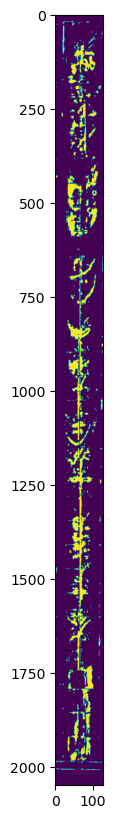

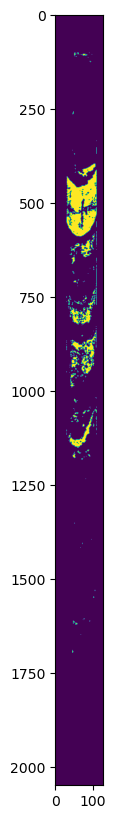

In [59]:
# plot_img(np.transpose(img.cpu().detach().numpy()[0,:,:,:],[2,1,0]).astype('float'))
# plot_img(np.transpose(mask.cpu().detach().numpy()[0,:,:],[1,0]).astype('float'))
plot_img(outputs)
plot_img(outmasks)

# Dice score evaluation

In [60]:
from scipy.spatial.distance import dice
def dsc(im1,im2):
    return 1-dice(im1.flatten(),im2.flatten())

def IOU(im1,im2):
    return np.sum(im1*im2)/np.sum((im1+im2)>0)

In [23]:
dsc(outputs,outmasks)
IOU(outputs,outmasks)

NameError: name 'outputs' is not defined

In [61]:
av_dsc = 0
# train_loader, val_loader = create_dataset(path, label_path, 'sericite',1) #Returns data loaders
train_iter = iter(train_loader)
val_iter = iter(val_loader)

for i in range(len(train_loader)):
    img, mask = next(train_iter)
    img = img.to(device)
    mask = mask.to(device)
    outputs, outmasks = infer(modelpath,img,'chlorite',class_min_dict,mask)
    av_dsc += dsc(outmasks,outputs)
    
print('Average training dice score: ', av_dsc/len(train_loader))

av_dsc = 0
for i in range(len(val_loader)):
    img, mask = next(val_iter)
    img = img.to(device)
    mask = mask.to(device)
    outputs, outmasks = infer(modelpath,img,'chlorite',class_min_dict,mask)
    av_dsc += dsc(outmasks,outputs)
    
print('Average val dice score: ', av_dsc/len(val_loader))
    

Average training dice score:  0.07344207872105989
Average val dice score:  0.07423362787133206


Bad pipe message: %s [b'\xc0\xe2g\xba\xbcSsh\x0f\x1b\x1a\xbeA\xfd\xe8\xabeC\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0']
Bad pipe message: %s [b"\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x000\x00.\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b"]
Bad pipe message: %s [b'\x08\x05\x08\x06\x04\x01\x05']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'', b'\x03\x03']
Bad pipe message: %s [b"\xd8\xee\xec\x8d\xfa\x1d\xf5\x80\x04\x1eHR\xb8/xr\x06Q\x00\x00\xa6\xc0,\xc00

Bad pipe message: %s [b'jy\xb7<\xbcI\xb0\x05\x9c6w{e\xc6\x16\xc1\x1f" \rvUW~g1\xf9\xa5\xf8\xee\x8d\x12\xfb\x8dS\x05\x92\xf9\x1e\x95\x1b\xeb\x17\xedvl\xf3\xd4Hx3\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f']
Bad pipe message: %s [b'k\xc7F\xech\xee\x85>C\xf0O']
Bad pipe message: %s [b"\xe7\xd6\xb7\xc1:/}M\x95\n%Y\x7fc\x14\xbc\x9a\xff\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0s\xc0w\x00\xc4\x00\xc3\xc0#\xc0'\x00g\x00@\xc0r\xc0v\x00\xbe\x00\xbd\xc0\n\xc0\x14\x009\x008\x00\x88\x00\x87\xc0\t\xc0\x13\x003\x002\x00\x9a\x00\x99\x00E\x00D\xc0\x07\xc0\x11\xc0\x08\xc0\x12\x00\x16\x00\x13\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00\xc0\x00<\x00\xba\x005\x00\x84\x00/\x00\x96\x00A\x00\x05\x00\n\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\

Bad pipe message: %s [b'\x90\xed\xc7\x12\xa3q\xd1\x96\xc8\xa4_\xe3"4\x87\x1a\xa9\x98 Dz\x82s*\xf0"sk#\xa2\xf4\xc7\x0e;\xa7,\x08\x00\x1e\xafR\x01\xdf\xfdB\xea\xb8Sf\xba\xa2\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-']
Bad pipe message: %s [b"\xc1\x8c\xbdyr\x84Y(/\xef\xb3]\xc0\xcc\x18;\xf7\x06\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00

Bad pipe message: %s [b'\x9f=G\xd8&\xf3W\xbf\x0b\x17m\xcd\x80U\x01\x9aF  \x8e\xd0\x13\xed_\xf4\x7fK\xb6~\x8a\xae\x14T1\xdcJ\xbf8\x18\x7f\xbbC\xb85H\xf9\xd3\x06\xf8Lg\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t12', b'0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08']
Bad pipe message: %s [b'\x08\x08\t\x08\n\x08']
Bad pipe message: %s [b'\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'f\x01\x158\x84\xb5\xa28T\xd4[}\xc0X\nF\t\x11 \xcd\xe27\x1eC\x87\xce\xbe\x95 z\xbdit\xb8\xbd\xa85\xfd|\xcd}$e\x08J>\xb5]p\xe8\xbf\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e

Bad pipe message: %s [b"\xdcrL[\xc6>}\xd0\xa92B\x0bPo\xfbZ&N\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0s\xc0w\x00\xc4\x00\xc3\xc0#\xc0'\x00g\x00@\xc0r\xc0v\x00\xbe\x00\xbd\xc0\n\xc0\x14\x009\x008\x00\x88\x00\x87\xc0\t\xc0\x13\x003\x002\x00\x9a\x00\x99\x00E\x00D\xc0\x07\xc0\x11\xc0\x08\xc0\x12\x00\x16\x00\x13\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00\xc0\x00<\x00\xba\x005\x00\x84\x00/\x00\x96\x00A\x00\x05\x00\n\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127", b'.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x000\x00']
Bad pipe message: %s [b'\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x03\x03\x02\x03\x03\x01\x02\x01\x03\x

Bad pipe message: %s [b"\x05\x88-'!~\xbb6\x91]\x8e\xa3v5M\x86\xc0\x19\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0", b'\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x000\x00.\x04\x03\x05', b'\x03\x08']
Bad pipe message: %s [b'\x08\x08\t\x08\n\x08']
Bad pipe message: %s [b'\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06']
Bad pipe message: %s [b'', b'\x03\x03']
Bad pipe message: %s [b'B\x95/\xa4\\']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'\xd1\xe7\x052d\xc6?\x1a\x14`3\x00\x

Bad pipe message: %s [b'\xe6\xe8h\xedI\x8e/Y\xb5\x90e\x08o\xb8-Z!V \x10U\x8f\xfa_\x1a\x8c\xc8db\xe5\x9f\xe4`4pl\xac\x81\xcd[K\xe5;`\xd4/\xa3\xcc&\x8d}\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04', b'\x01\x02']
Bad pipe message: %s [b'=\xf9\xe5"\xd9\x94}Y\xa4j\xbfg\x16?\xc3\xe4\x16\x7f\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0\'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00', b'<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00']
Bad pipe message: %s [b'\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x000\x00.\x0

Bad pipe message: %s [b'[Z\xffL\xf2\xb8\xe4\x11)\x12#!P\xd6\xa4\xe3M\x15 \x05\xf0\x8d<\x1d>\xd2\x05pa\xd8Y\xa0k\xe9%\xc3\x8e!\x08/\x96|\xe17\xa8!\xadM}\x88\xe1\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00']
Bad pipe message: %s [b'']
Bad pipe message: %s [b"uo\xb8\xab\xd9N\x186\xb5\x8c\xe8\xd0\x16\x1e\x11.\xb9o\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\

Bad pipe message: %s [b"2L\x16\x08\x18y\xfc\xec\x0f\xf1\x1bt\xed\x93&\xcb\x97\x10\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0"]
Bad pipe message: %s [b"\xd7ao\xa6\x13\x96e\x17\xb6\xb3\ty\x85\xa3\xe3\xdfF\xed\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0s\xc0w\x00\xc4\x00\xc3\xc0#\xc0'\x00g\x00@\xc0r\xc0v\x00\xbe\x00\xbd\xc0\n\xc0\x14\x009\x008\x00\x88\x00\x87\xc0\t\xc0\x13\x003\x002\x00\x9a\x00\x99\x00E\x00D\xc0\x07\xc0\x11\xc0\x08\xc0\x12\x00\x16\x00\x13\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00\xc0\x00<\x00\xba\x005\x00\x84\x00/\x00\x96\x00A\x00\x05\

Bad pipe message: %s [b"i5\x86\x06$\xa7\x1d4\x16\x0f\xcec\x8e\xe8\x06k\xa8z\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.", b'0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x000\x00.\x04\x03']
Bad pipe message: %s [b'\x06\x03\x08\x07', b'\x08\t\x08\n\x08\x0b\x08']
Bad pipe message: %s [b'\x05\x08\x06']
Bad pipe message: %s [b'\x05\x01\x06', b'', b'\x03\x03']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'\xff\x033\x89_\xc4\x0c\x1c\xa9\xba^L\xe5[T\xdf\xea', b'\x00']
Bad pipe 

# Basic visualization

In [23]:
def register_imgs(img_path, label_path,mineral_type):
    '''Registers an image with its mask and returns both'''
    im1 = cv2.imread(img_path)
    im2 = cv2.imread(label_path)
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

    j2k = glymur.Jp2k(img_path)
    j2k2 = glymur.Jp2k(label_path)

    rgb_tiepoint = j2k.box[3].data['ModelTiePoint'][3:6]
    cm_tiepoint = j2k2.box[3].data['ModelTiePoint'][3:6]
    rgb_res = j2k.box[3].data['ModelPixelScale'][0]
    cm_res = rgb_res*10

    rgb_box = (rgb_tiepoint,rgb_tiepoint+[im1.shape[1]*rgb_res,-im1.shape[0]*rgb_res,0])
    cm_box = (cm_tiepoint,cm_tiepoint+[im2.shape[1]*cm_res,-im2.shape[0]*cm_res,0])


    im1 = cv2.copyMakeBorder(im1, -min(int((rgb_box[0][1]-cm_box[0][1])/cm_res),0),
                              max(int((rgb_box[1][1]-cm_box[1][1])/cm_res),0),
                              max(int((rgb_box[0][0]-cm_box[0][0])/cm_res),0),
                              -min(int((rgb_box[1][0]-cm_box[1][0])/cm_res),0),
                             cv2.BORDER_CONSTANT)
    im2 = cv2.copyMakeBorder(im2, max(int((rgb_box[0][1]-cm_box[0][1])/cm_res),0),
                              -min(int((rgb_box[1][1]-cm_box[1][1])/cm_res),0),
                              -min(int((rgb_box[0][0]-cm_box[0][0])/cm_res),0),
                              max(int((rgb_box[1][0]-cm_box[1][0])/cm_res),0),
                             cv2.BORDER_CONSTANT)

    im1 = cv2.resize(im1, (128,2048))
    im2 = cv2.resize(im2, (128,2048), interpolation=cv2.INTER_NEAREST)


    mask = create_mask(np.transpose(im2,[2,0,1]),mineral_type,class_min_dict)
                     
    return im1, mask
                     
def plot_img(img):
                
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    return

def plot_img_mask(img,mask):
    '''Overlay 1-channel mask on 3-channel image'''
    mask = np.expand_dims(mask,axis=-1)*255
    mask = np.concatenate([mask,mask,mask],axis=-1).astype('float')
    plt.figure(figsize=(10,10))
    dst = cv2.addWeighted(img,0.5,mask,0.7,0)
    plt.imshow(dst[:,:,:])
    return



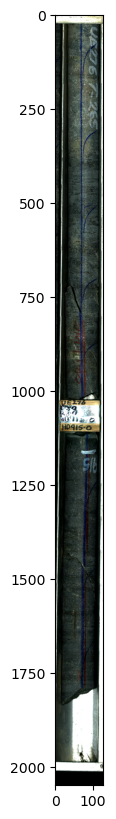

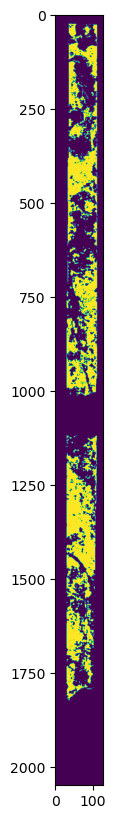

Bad pipe message: %s [b'\x83\xfe9\xaf\xd7a\x06!\xa7\x8b\xa7O\xcc\x9bI1~\xd0 \xeb\xae\xb6OGx\x05v\x00', b'\xdd\x03\x14}G}\xa6H\xe4)\x88\x97\x8aU\x94\xb6\xc8@RX\x9c\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \x89\x9b\xddK\xbc\xbe\x13\x88\x13%\xc3\x0e']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'\xfd\x96\xcfml\xe1{\xc52\xb9E\x83\x99:lD;\x1b\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+', b"\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc

Bad pipe message: %s [b'B&*C\x18wM\xae\x144\xdc\x80`\x17\x1aQ\xecS Uq\x85\xf4\xf3r?\xfb%\xbc\xbe\xe6']
Bad pipe message: %s [b'\x8c\x97\x87\x10\xf4\xeb\xaf\x0c\xab\x7fK\xc1\xce\x1b>\x19\xc2\x19 O$L\x07`\x8cvp\x84\xc1?\xeev\xee\xd8P\xa2\xb7O\xd0\x8bWKc\x99\xf9N\xb0Y']
Bad pipe message: %s [b'W\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01\x01']
Bad pipe message: %s [b'\x93\xd7', b"l\xb3O\xee\n\xf9\x8b\xae9Z\r\x89Po\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\

Bad pipe message: %s [b'Yx\x07f\xca\x1d\xdfS\x0f0\x951#\xa5\xe07]\xbb \xeeb\xb2\x16o\t.\xac\x82O\xafX\xe6\xa5\x1c\x96\xe8\xd7\x19`\xf8\xc1G\xfd\x1e<3\xdc\x90.\xa2\x1a\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 @Q\xfaH']
Bad pipe message: %s [b"\xfb\x81\xc6\xa2\xa0\xa6\x1d\x96\xe6\xd6\x1bqi\x0f\x8a\x96\x99\x0f\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1

Bad pipe message: %s [b"\x15@V\x1cZ\xad\xa9\xadtJ\xe5\x86\xe4q\xd4(\xbd?\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x000\x00.\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x03"]
Bad pipe message: %s [b'\x03\x03']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'', b'\x02']
Bad pipe message: %s [b'\x05\x02\x06']
Bad pipe message: %s [b'\x8aP\x96?,\x1f\xd2#q\x7f.\xebq

Bad pipe message: %s [b'\x7f\x1b\xf8\x84n\x04\xbdS\xc3\x8e']
Bad pipe message: %s [b'C\xc8$c\xb7!mc\x9a\xe1Pp\x8c\xd8W;\xab\xb1\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k']
Bad pipe message: %s [b'\x0bUT\x98<\xc3\x1b\x86\xa5\xa9\x80\xef\xe3;2m\xbd\x15\x00\x00>\xc0\x14\xc0\n\x009\x008\x007\x006\xc0\x0f\xc0\x05\x005\xc0\x13\xc0\t\x00', b'2\x001\x000\xc0\x0e\xc0\x04\x00/\x00\x9a\x00\x99\x00\x98\x00\x97\x00\x96\x00\x07\xc0\x11\xc0\x07\xc0\x0c\xc0\x02\x00\x05\x00\x04\x00\xff\x02\x01\x00\x00C\x00\x00\x00\x0e\x00\x0c\x00\x00']
Bad pipe message: %s [b'T\x1a\\1&\x9e;\xcd\xc0b\xc3\xfb-\x13J\xcc3\x87\x00\x00\xa2\xc0\x14\xc0\n\x009\x008\x007\x006\x00\x88\x00\x87\x00\x86\x00\x85\xc0\x19\x00:\x00\x89\xc0\x0f\xc0\x05\x005\x00\x84\xc0\x13\xc0\t\x003\x002\x001\x000\x00\x9a\x00', b'\x98\x00\x97\x00E\x00D\x00C\x00B\xc0\x18\x004\x00\x9b\x00F\xc0\

Bad pipe message: %s [b"\xd3\x04\t\xb8n\xb9h\xa4\xb2\xa8\t\x0e\xdc\xa6g\xe3\x177 |\xa4\xdf\xf7\xaa\x17\xab\x93\x90\xb3\x08\xa1(\x85\x16\xb9\x98@2\xb3\x8a\x03\xc2\xa5\xfe\xc5\x80t0\x1a'2\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00", b'\x03\x07\xab\xc1\xdb\x9b\x8a*\xb6\xd0i\xbf\x91\xa3`\xccL\xe0iO\x9f:+\x10\xe8\xbd\xe4\xe94x ']
Bad pipe message: %s [b'\x18Kz\xac%\x8fGW<\x9e\x8b\x89\x88\x0b\xcfC\xdcP\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa']
Bad pipe message: %s [b"\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\

Bad pipe message: %s [b")\x04\xc8\x1b\xb2\xbd\x82\x89\xe2mn\x17\xa2\xdd\xa34q\x11 *YGo\xa0\xe87\xa2\x8b3\xe8\x97\xe2~\xfdkQ'\x11\xfad\x95\xed\x11\x8e}D\xbfU\x02m", b'\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01']
Bad pipe message: %s [b"z\xf5\xf5\xc9G\x19\xf6\xf8U\xc0i,\x02S\x9c\xe9R\x10\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00", b'5\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\x

Bad pipe message: %s [b'\xe5O5\xd5x\x9d^\x99\x1f\xaa\xd9\xa6\x8a3\xa1\xb6{', b'p;\xca\xf4 \x15f\xed\xba\xf9\xaa\xd7\xa6G\xf7\x83\\\xce\xbf\x03,\x83zg9\xb3\x05\x82J\x07\x8c\x82\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t12']
Bad pipe message: %s [b'0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08']
Bad pipe message: %s [b'\x08\x08\t\x08\n\x08']
Bad pipe message: %s [b'\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \x98\x1a\xdc\xb2U3\xdb\xf3\x92\x8d!\xf1\x94\x98_\x81\xd7_\xd6\xfc\xaf\xbc']
Bad pipe message: %s [b"\xc1s\xf2T\x1f\xad\x04\x91\xcb\xa9\x10\x81\xcd\xc1p\x7f\x8b\xa7\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\x

Bad pipe message: %s [b'\xe1$\xfb\xc9A\xd8BW\x88\xb3\xe8\xe6\'\x81V|p\xfa \xf3\x01\xe8\xcc\xf0l\xb2\xb2\xcb\xa8c8\xcf~m@\xf9\xc2\x07\xef\xd7R\x19\xd9mV\x8f\rG\x90"}\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01']
Bad pipe message: %s [b'\xc0\xb5\x002\x0e\x9a\xde\x86C}~\xee9=Y#J\x14\x00\x00|']
Bad pipe message: %s [b"\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x000\x00.\x04\x03\x05\x03\x06"]
Bad pipe message: %s [b'\x07\x08']
Bad pipe message: %

Bad pipe message: %s [b'\xa7\xbck\xecJNk\xf1\xf4\x83\x07\xed\xa4;a\x14\x1f\r .\nBD\xcb\xcdN\x86\x7f\x1f\xa9\x96\x03\xd5\x03\xe1\nu0\xd9\xab\x02\x8e\xc6\xae\xffQ\xaat`\xa9\x97\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04']
Bad pipe message: %s [b'', b'']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 $@\xed\n\xa8\x96W/W>\xe5\xe8\x0ffu\xdd\xa1!\xd4v9\xf6']
Bad pipe message: %s [b"\xcc!\xb1\xfb\xed\x05E\xaa\xb5\xe6\xc4\xde\xa3\xf3\x12\xe9l\xdf\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\

Bad pipe message: %s [b'\x9b\xca\xcdJ\xf9f\xb4n\xaejl\xf28\x8f\xff\xedz\x7f \x18\xdd\xea#\xbd \xc8\xa3;\xbbq\x90\xcc;@%QG\x8b\xfc\xf4\xb1\x8fsvl\x1f\xee\x1dk\x9a\xa6\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'\xb2\xde\x10\x9e\xaesp1Gc\x9a\xc0\xaa\x19\x07\xdf|\xc5 .\xc8A~h\x9e/\x85\x8b\x0b.\x9e\x85\x82\x18\xb7!\xc8\x13\\\x1be\t\xd2\xee;\xaa\x01\xe8\x91\x05\x1e\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \x00+\xd7N\xccs)b\r\xfaR\x80\xf8\xf7\x1e\xa1X?x\xecx\xb1']
Bad pipe message: %s [b'6;\x1d\xd6f\xc7gD\xb01\x1

Bad pipe message: %s [b'\xa7\xbe\xc3\xc2|\xf3@M\x1a\xaa\xf9"\xe6\x86(\x96\xa3\x88 I\\P\x82\x83\x1f+\xb5x\x96\x07\xa1\xf5\x8aP\xc0\xaf\xcfa\xe4\xe8Nf\xab\x18\x84\xa1O\xb0\xa0%`\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00', b'\x1d\x00 U\xa7\x9d\xc4\xff\xdc\xda\xb9\xaa\x8ci\x9e\x89D\x184>\x9f\xffbCMO4\r\xfc\xb9w\xa6\xd9\xbfk']
Bad pipe message: %s [b'\xf3\x8e\x18o+\xeaTzq\x167F\x8b\xdd\x9c^\xd3% \xdc?I\xfd\xf3\xaf\x18r\xb2\nD\xa8G\x0f6Js\x8e\xab\xb9u\x99\x9bu\xd5V|\x08\xf9]\xac\xd6\x00']
Bad pipe message: %s [b'\x02\x13\x03\x13\x01\x00\xff', b'']
Bad pipe message: %s [b'T\xf8\x8f\x02\x92\xe8r\xeb\x8a\xb6\x95 \xd7S

Bad pipe message: %s [b'\xf7\xf5F\xaf\x8c\xce\xbd\xa9\xd3\xdd\x01^\x8c\x0fu\xc9\xfa\xe0 \xef\xf4\xa8(\xed\xa2"\r7\xdf7/\xa2\x96\x03']
Bad pipe message: %s [b'K\xea\x97\x91\x80\x95U']
Bad pipe message: %s [b"\xb5\xba\x8b\xf2`^\xa7\xf7\xb7\xb5\xb1X\xb4]Ga,^\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0s\xc0w\x00\xc4\x00\xc3\xc0#\xc0'\x00g\x00@\xc0r\xc0v\x00\xbe\x00\xbd\xc0\n\xc0\x14\x009\x008\x00\x88\x00\x87\xc0\t\xc0\x13\x003\x002\x00\x9a\x00\x99\x00E\x00"]
Bad pipe message: %s [b'\x07\xc0\x11\xc0\x08\xc0\x12\x00\x16\x00\x13\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00\xc0\x00<\x00\xba\x005\x00\x84\x00/\x00\x96\x00A\x00\x05\x00\n\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127']
Bad pipe message: %s [b'.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x

Bad pipe message: %s [b'\xa3\xa2\xaf\x91\x1d ulbij\nSL\x8ao\xb3\xdb \x9b\xc4\x0b\x0c\xaaJ\x18@M\xa5\xecL,\x8eNz\xb9V\xfd\x00A\x84C\xf2\x08A\xe3:7k\xae\x93\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \r:BR\xf0=\xec$\xf9i\xfb\xf1\xcde\xa0\xf5\x9c\x1c\x0b\x01\x0f\xe2\xcd\xf9?n\x81\xb9']
Bad pipe message: %s [b'*\xa9\xf2\xc9\xf8\xcd;Sec\x89}x\xdc\xf5\x82_\xef \xdd2B\x9e\x84\x18\xe7\x07s^\xb8\x9a\xf9\xd5O\x88\x8d\xfb\xeb\xf1\xabr\xa9b\xb2\xf8\xf2\xd7g\xa4G`\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00

Bad pipe message: %s [b'0`\x1e\xb53\x88\xd3Y]\x98\xae\x01\xc1B-8VO\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+', b"\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x000\x00.\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x03\x03\x02\x03\x03\x01\x02\x01\x03", b'\x02']
Bad pipe message: %s [b'\x05\x02\x06']
Bad pipe message: %s [b'E<zF\n\xf4\x06\xbb\x90\xcbw\xcd\xbb\x9aK\x85Rm\x00\x00\xa2\xc0\x14\xc0\n\x009\x008\x007\x006\x

Bad pipe message: %s [b'c)\xcdl\xf6\xc76\xcf']
Bad pipe message: %s [b'\x9a@\xb4\xf2S%\xf6.|\x9c)\x82\x9dX[\xa6\x11E \xb7\xa5\xc4\x83\xfc\x91\xaa\xd6\xf0\xd7\x0e]\xb0\xb6\xec\x15tP\r\xc8\x08\x81P,\xf8\x83\x1b\x82[*\xa6G\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00']
Bad pipe message: %s [b"\x9b\xae\xe6\xa3\xef\xba\x13zDN\xc1\x15U8\xaa\x7f/\x1a\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1

In [67]:
path = '../img-rgb-50u'
label_path = '../img-clm-phy'
alt_label_path = '../img-sm-chl'
img_list = sorted([i for i in os.listdir(path) if os.path.isfile(os.path.join(path, i))])
label_list = sorted([i for i in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, i))])


img, lab = register_imgs(os.path.join(path,img_list[0]),os.path.join(label_path,label_list[0]),'chlorite')
plot_img(img)
plot_img(lab)

## TODO:

- Talk to Brain about mask
- Try different learning rates
- Try different optimizer

In [47]:
def collage(modelpath,val_loader,mineral_type,class_min_dict,savepath):
    val_iter = iter(val_loader)
    for i in range(len(val_loader)):
        plt.subplot(2,len(val_loader),i+1)
        img, mask = next(val_iter)
        img = img.to(device)
        mask = mask.to(device)
        outputs, outmasks = infer(modelpath,img, mineral_type,class_min_dict,mask)
#         outputs = outputs>0
        plt.imshow(outputs,cmap='gray')
        plt.subplot(2,len(val_loader),i+len(val_loader)+1)
        plt.imshow(outmasks,cmap='gray')
    plt.savefig(savepath)
    return

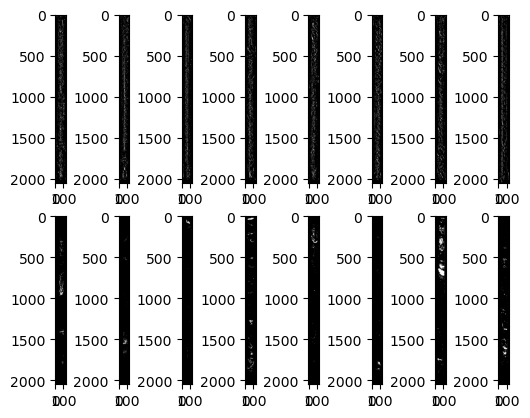

In [48]:
collage('../saved_models/patch_chlorite_newmask190_lr0_01.pt',val_loader,'chlorite',class_min_dict,'output_chlorite_newmask190.jpeg')

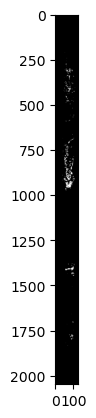

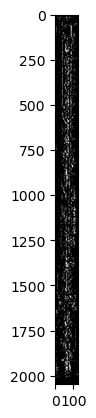

In [53]:
val_iter = iter(val_loader)
img, mask = next(val_iter)
img = img.to(device)
mask = mask.to(device)
outputs, outmasks = infer('../saved_models/patch_chlorite_newmask190_lr0_01.pt',img, 'chlorite',class_min_dict,mask)
plt.figure()
plt.imshow(outmasks,cmap='gray')
plt.figure()
plt.imshow(outputs>0.1,cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


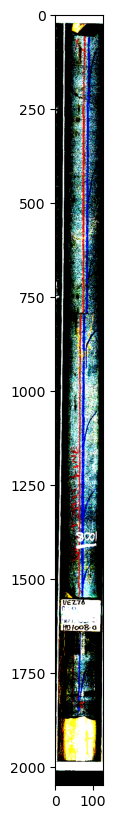

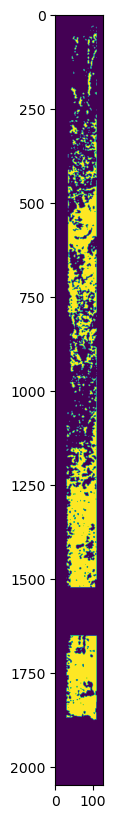

In [170]:
# val_iter = iter(val_loader)
# img, mask = next(val_iter)
plot_img(np.transpose(img.cpu().detach().numpy()[0,:,:,:],[2,1,0]).astype('float'))
plot_img(np.transpose(mask.cpu().detach().numpy()[0,:,:],[1,0]).astype('float'))
# plot_img_mask(np.transpose(img.cpu().detach().numpy()[0,:,:,:],[2,1,0]).astype('float'),np.transpose(mask.cpu().detach().numpy()[0,:,:],[1,0]).astype('float'))